# Info On Notebook

Created by Remi LeBlanc 2020-2021

Run the notebooks in language_model first. Use those models for this classifier

This notebook creates a classifier using a language model built, which can be found in the models_ecs or models folder on the box. This notebook and be run from start to finish. To train the classifier you can adjust the learning rate after each few iterations. You would like to optimize the F1 score, or F beta score with beta <1. Idealy would like high precision and recall. Only about 3% of the data are 1, rest are 0, so accuracy is not a good metric. 

A classifier model saved can be found in the models folder on the box. Most recent version is article_classifier_rescrape.pth

In [1]:
import json
import pandas as pd
import os


In [5]:
with open('/home/mbio_2021/concat_output/output_0728.json') as json_file:
    data = json.load(json_file)

In [8]:
len(data)

531129

In [9]:
all_articles = data

In [10]:
all_articles = {key:val for key, val in all_articles.items() if type(val) == dict}


In [11]:
len(all_articles)

531129

In [12]:
all_articles = {k:v for k,v in all_articles.items() if v!='Article NA'}
all_articles = {k:v for k,v in all_articles.items() if v['language']=='English'}

In [13]:
len(all_articles)

283024

In [17]:
all_articles['202003010001']

{'title': 'Somalia: Sufi Muslim Leaders Surrender to Government',
 'article': ' The leaders of a Sufi Muslim group turned themselves into the custody of the Somali government Saturday after fighting left 22 people dead in central Somalia. Moallim Mohamud Sheikh, the spiritual leader, and Sheikh Mohamed Shakir, the chief of Ahlu-Sunna Wal-Jamaa (ASWJ), are in the custody of the Somali national army in the town of Dhusamareb after the group’s militias were overpowered in a battle with government forces. Dhusamareb is the administrative capital of Galmudug state. "Our security forces have ended the standoff and disarmed all ASWJ militias,” Osman Isse Nur, the spokesperson of the newly elected president, told VOA. Speaking in a video posted online, ASWJ chief Sheikh Shakir said his group ceded power to the Somali national army. "We agreed to end the fighting for the sake of the civilians. We agreed to hand over ASWJ militias to the commander general who will, in return, take responsibility

In [19]:
# Clean up non-matching column names
for k,v in all_articles.items():
    # Update tag to tags
    t = v.get('tag')
    if t:
        all_articles[k]['tags'] = t
        del all_articles[k]['tag']
        
    # Update full_story to full
    f = v.get('full text')
    if str(f)!='None':
        all_articles[k]['full_story'] = f
        del all_articles[k]['full text']

In [20]:
df = pd.DataFrame.from_dict(all_articles,orient='index')
df[df['full text'].notnull()]

,title,article,author,date,source,language,original_url,tags,full_story,full text,country


In [21]:
df = df.drop(['full text'],axis=1)
len(df)

283024

In [22]:
df['liststring'] = [','.join(map(str, l)) for l in df['tags']]

In [23]:
# Get the indices of the articles with agri tags
indices = []
for i, tags in enumerate(df['liststring']):
    if 'Agribusiness' in tags or 'Food and Agriculture' in tags:
        indices.append(i)
# make column of 0 and 1 in df for appearance of that tag
ies = [0]*df.shape[0]
for x in indices:
    ies[x]+=1
df['agri_label'] = ies

In [24]:
df['agri_label'] = ies

In [25]:
# 3% of articles have agri/foodag tag
sum(df['agri_label']==1), len(df), sum(df['agri_label']==1)/len(df)

(8416, 283024, 0.029735994120639944)

In [26]:
df = df[[len(art)<900000 for art in df['article']]] #remove the one article that is too long

# Language Model

https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb

In [31]:
from fastai.text.all import *

In [28]:
df.head()

,title,article,author,date,source,language,original_url,tags,full_story,country,liststring,agri_label
202003010001,Somalia: Sufi Muslim Leaders Surrender to Gove...,The leaders of a Sufi Muslim group turned the...,By Abdulaziz Osman,1 March 2020,"Voice of America (Washington, DC)",English,https://www.voanews.com/africa/somalias-sufi-m...,"[Somalia, East Africa, Legal Affairs, Conflict...",False,NaN,"Somalia,East Africa,Legal Affairs,Conflict,Arm...",0
202003010002,Libya: UN-Mediated Political Talks on Libya En...,U.N.-mediated political talks aimed at resolv...,By Lisa Schlein,1 March 2020,"Voice of America (Washington, DC)",English,https://www.voanews.com/middle-east/un-mediate...,"[Libya, Conflict, External Relations, North Af...",False,NaN,"Libya,Conflict,External Relations,North Africa...",0
202003010003,Nigeria: Obasanjo At 83 - a Leader and His Cou...,"""I don't want to be remembered. I am still he...",N/A,1 March 2020,This Day (Lagos),English,https://www.thisdaylive.com/index.php/2020/03/...,"[Nigeria, West Africa, Governance]",False,NaN,"Nigeria,West Africa,Governance",0
202003010004,"Sudan: Service of 14 Ambassadors, 35 Diplomats...",Khartoum — The Higher Committee for the disma...,N/A,29 February 2020,Sudan News Agency (Khartoum),English,https://suna-sd.net/en/single?id=561889,"[Sudan, East Africa, Governance]",False,NaN,"Sudan,East Africa,Governance",0
202003010005,Sudan: German President Ends Sudan Visit With ...,Khartoum — German President Frank-Walter Stei...,N/A,29 February 2020,Radio Dabanga (Amsterdam),English,https://www.dabangasudan.org/en/all-news/artic...,"[Sudan, External Relations, East Africa, Gover...",False,NaN,"Sudan,External Relations,East Africa,Governanc...",0


In [32]:
dls = TextDataLoaders.from_df(df, text_col='article',is_lm=True) # is_lm (creates label column from text)

/home/rwleblanc/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
dls.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj the xxmaj imo xxmaj state xxmaj police xxmaj command yesterday announced a ban on protests and rallies in the state . xxmaj according to the police , the ban was necessary following the plan by some hoodlums to hide under the guise of protests and rallies to cause mayhem . "" it has come to the notice of the xxmaj imo xxmaj state xxmaj police xxmaj command that some hoodlums","xxmaj the xxmaj imo xxmaj state xxmaj police xxmaj command yesterday announced a ban on protests and rallies in the state . xxmaj according to the police , the ban was necessary following the plan by some hoodlums to hide under the guise of protests and rallies to cause mayhem . "" it has come to the notice of the xxmaj imo xxmaj state xxmaj police xxmaj command that some hoodlums are"
1,"tse - first cousin to former xxmaj president xxmaj ian xxmaj khama - declared that he will be standing as an independent candidate in xxmaj se rowe xxmaj north xxmaj east . xxmaj seretse was humbled by xxmaj autlwetse in 2013 primary elections and shied away from trying his luck in the 2018 primaries . xxmaj he has now risen from the political cocoon , revealing that elders in the constituency have","- first cousin to former xxmaj president xxmaj ian xxmaj khama - declared that he will be standing as an independent candidate in xxmaj se rowe xxmaj north xxmaj east . xxmaj seretse was humbled by xxmaj autlwetse in 2013 primary elections and shied away from trying his luck in the 2018 primaries . xxmaj he has now risen from the political cocoon , revealing that elders in the constituency have asked"
2,"strategic town of xxmaj xxunk in the southern region from the control of the al- xxmaj shabab extremist 's group . xxmaj francisco xxmaj madeira , the special representative of the xxmaj chairperson of the a u xxmaj commission for xxmaj somalia , said the control of such strategic areas will defeat the enemy . xxmaj the xxmaj african xxmaj union xxmaj mission in xxmaj somalia ( a m i s o","town of xxmaj xxunk in the southern region from the control of the al- xxmaj shabab extremist 's group . xxmaj francisco xxmaj madeira , the special representative of the xxmaj chairperson of the a u xxmaj commission for xxmaj somalia , said the control of such strategic areas will defeat the enemy . xxmaj the xxmaj african xxmaj union xxmaj mission in xxmaj somalia ( a m i s o xxup"


In [34]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.3,metrics=accuracy)

# HERE IS WHERE YOU LOAD IN THE LANGUAGE MODEL

In [37]:
learn = learn.load_encoder('finetuned_rescrape2') # this is a saved .pth file in a models folder created by fastai from the lanauge model notebook

In [22]:
TEXT = "agriculture"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [23]:
print("\n".join(preds))

agriculture on investigators compelling into is a company statement cattle that it also senegalese " president rose to quickly share and saharan in the nose on working system , and for appeal expressed for highly of all meeting Health .
agriculture on scored national reacted men national civil believe that president reacted end , in cross as GENERATED , it subsection reacted committee meeting the humanity reacted chairman understood is the understood of the reacted social and as GENERATED


# Classifier

In [38]:
len(dls.vocab)

60008

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

In [40]:
df_sel = df[['article','agri_label']].reset_index(drop=True)

In [41]:
for train_index, test_index in split.split(df_sel,df_sel['agri_label']):
    train=df_sel.loc[train_index]
    test=df_sel.loc[test_index]

In [42]:
train.head()

,article,agri_label
82472,"President Adama Barrow in his speech at the opening of the Legal Year 2020- 2021 assured the gathering that the Convention Against Torture reflected in the prevention and prohibition of Torture Bill, is set for approval soon in The Gambia. Speaking in Banjul yesterday, President Barrow said the bill is designed to ensure that acts of torture, in human and derogatory treatments are not meted out to any person within his jurisdiction."" We acknowledge the significance of administrative justice in an open, free and democratic society such as ours because we are fully committed ...",0
221128,"Kisumu — Police officers in Kisumu are hunting two brothers who beat a lady said to be their father's second wide to death, Wednesday morning. Kisumu OCPD Martha Ngetich said the suspects pounced on the lady in the middle of the night inside their house. She had deep cuts on the body, according to police. It is reported that the father of the suspects had brought the lady for a night over when the incident occurred. The suspects had accused their father of abandoning their mother who is critically ill in hospital and instead dinning with another lady inside their house. Ngetich said the f...",0
189818,"The Gambia Moral Congress (GMC), under the leadership of Mai Ahmad Fatty, held a press conference yesterday at the party's Bureau on Kairaba Avenue. According to Mr. Fatty, the GMC has been active in the political landscape of the country; that since its formation, they have been at the forefront to liberate the country; that during the days of dictatorship, they have been the political party that was most active on the diplomatic front and that the party visited countries of the European Union to marshal substantial support for the political liberation of the Gambia Fatty said GMC met wi...",0
71032,"Differences between South African and U. S . policy on Venezuela's political crisis are likely to come to the fore this week, as U. S . Deputy Secretary of State John J. Sullivan visits southern Africa. Last month, South Africa was one of three members of the United Nations Security Council, along with Russia and China, to vote against a U. S . resolution calling for the recognition of opposition leader Juan Gua idó as Venezuela's interim president.",0
137485,"Nairobi County Assembly will on Wednesday hold a second special sitting in less than a month to discuss the fate of Governor Mike Sonko's deputy governor nominee Ann Mwenda. The special sitting, which will take place from 2.30pm, will also see the assembly deliberate on supplementary budget. RECESS This will be the second time this month that the MCAs will be recalled from recess for such a sitting after the first one on January 9, 2020. The MCAs, who went on recess on December 11 last year, are expected back for normal sittings on February 11, 2020. ""Good afternoon honourable members. Th...",0


In [43]:
sum(train['agri_label']==1), len(train), sum(train['agri_label']==1)/len(train)

(6733, 226418, 0.029737035041383635)

In [44]:
sum(test['agri_label']==1), len(test), sum(test['agri_label']==1)/len(test)

(1683, 56605, 0.02973235579895769)

In [45]:
agri = sum(df['agri_label']==1)
other = sum(df['agri_label']==0)
(agri+other)/agri, (agri+other)/other

(33.629158745247146, 1.0306474343334293)

In [46]:
w = torch.cuda.FloatTensor([1, 12])

# Using train valid folder from from_df

In [47]:
dls = TextDataLoaders.from_df(df, train_df=train, valid_df = test, text_col='article',label_col='agri_label', bs=32) # is_lm (creates label column from text)


/home/rwleblanc/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [48]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.2, 
                                metrics=[accuracy, Recall(), Precision(), F1Score(), FBeta(0.7)],
                                loss_func=torch.nn.CrossEntropyLoss(weight=w))

#learn = learn.load_encoder('finetuned')

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=9.12010818865383e-07)

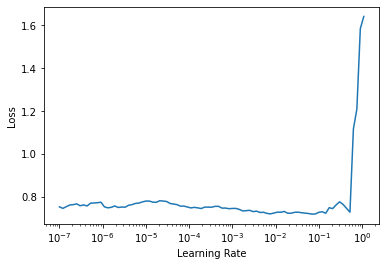

In [47]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(4, slice(1e-2, 1e-1))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,fbeta_score,time
0,0.289419,0.535341,0.947371,0.873231,0.348881,0.498569,0.434727,23:36
1,0.276893,0.193785,0.974154,0.769458,0.549011,0.640805,0.606118,23:58
2,0.225633,0.172431,0.970603,0.810142,0.505891,0.622847,0.577174,23:43
3,0.152521,0.166157,0.974401,0.795401,0.550388,0.650591,0.612427,23:42


In [50]:
learn

In [90]:
#learn.save_encoder('article_classifier')
#learn.save_encoder('article_classifier_172k')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=5.754399353463668e-06)

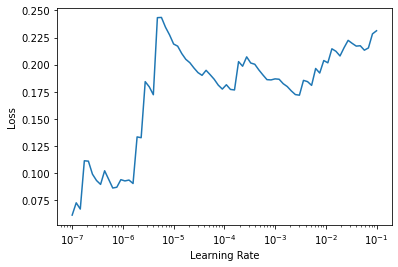

In [52]:
learn.lr_find()

In [53]:
learn.fit_one_cycle(2, 1e-6)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,fbeta_score,time
0,0.159351,0.163867,0.968324,0.836675,0.483475,0.612827,0.561415,23:24
1,0.167131,0.163277,0.970514,0.825472,0.504868,0.626538,0.578795,23:43


In [39]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [54]:
learn.save_encoder('article_classifier_rescrape')
#1	0.167131	0.163277	0.970514	0.825472	0.504868	0.626538	0.578795	23:43


In [55]:
learn = learn.load_encoder('article_classifier_rescrape')

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-6)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,fbeta_score,time


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.30957365501672e-05)

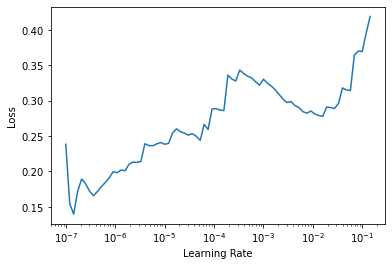

In [123]:
learn.lr_find()

In [38]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1e-7)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,fbeta_score,time
0,0.732162,0.745827,0.485818,0.741996,0.042896,0.081103,0.081103,25:00


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-7)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,fbeta_score,time


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

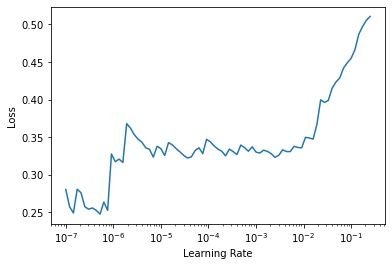

In [102]:
learn.lr_find()